## Importing Libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Preprocessing

In [41]:
data = "./AirQuality.csv"

In [60]:
df = pd.read_csv(data)

In [61]:
df["DateTime"] = df["Date"] + " " + df["Time"]
df = df[["DateTime", "CO(GT)", "T"]]

In [62]:
df = df.replace(-200, np.nan)
df = df[6:]

In [63]:
df[:168]

,DateTime,CO(GT),T
6,11-03-2004 00.00.00,1.2,11.3
7,11-03-2004 01.00.00,1.0,10.7
8,11-03-2004 02.00.00,0.9,10.7
9,11-03-2004 03.00.00,0.6,10.3
10,11-03-2004 04.00.00,NaN,10.1
...,...,...,...
169,17-03-2004 19.00.00,7.6,23.1
170,17-03-2004 20.00.00,6.7,20.5
171,17-03-2004 21.00.00,5.7,19.1
172,17-03-2004 22.00.00,2.8,17.2


## Forecasting Temparature(T)

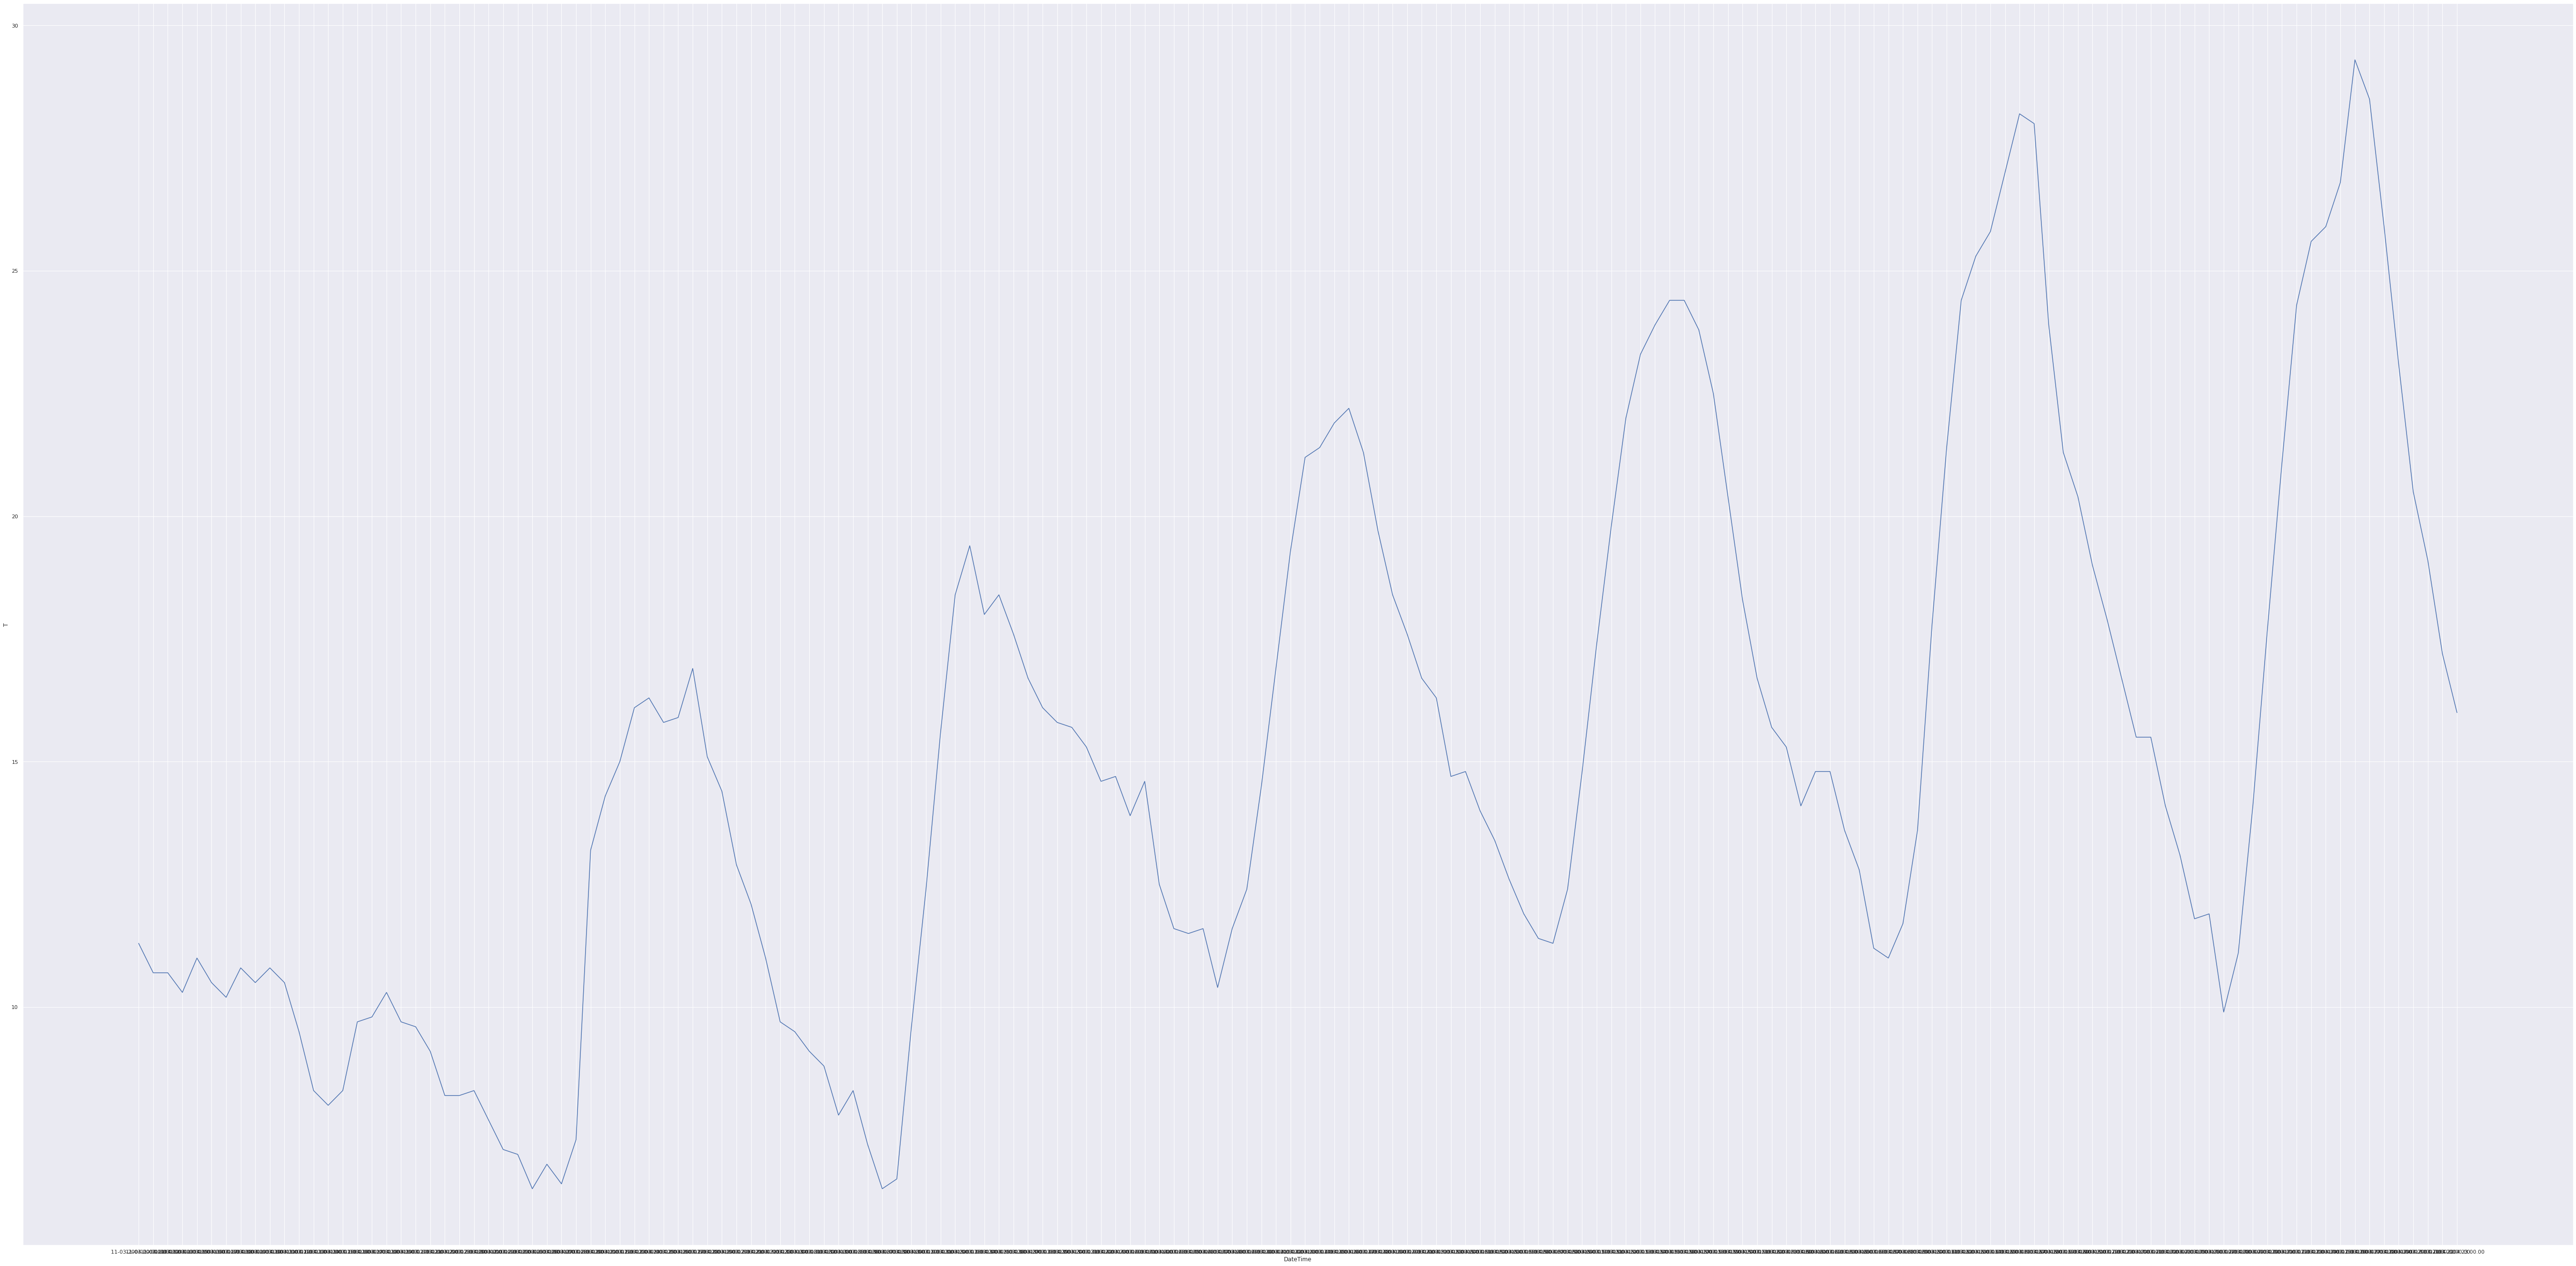

In [47]:
sns.set(rc = {"figure.figsize" : (96, 48)})
sns.lineplot(x = "DateTime", y = "T", data = df[:168].dropna())

In [39]:
# Dickey Fuller Test 
from statsmodels.tsa.stattools import adfuller
X = df["T"][:168].dropna()
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
#p-value < 0.05 for stationary 

ADF Statistic: -4.327264
p-value: 0.000398
Critical Values:
	1%: -3.471
	5%: -2.879
	10%: -2.576


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


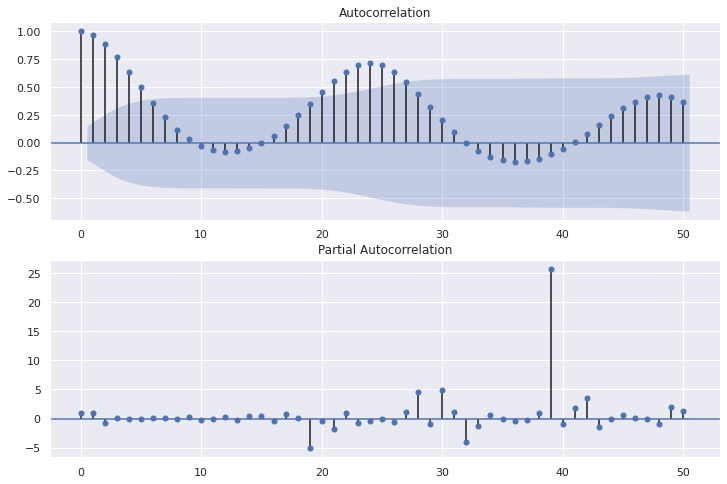

In [28]:
# Autocorrelation and Partial Autocorrelation
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df["T"].iloc[:168].dropna(), lags = 50, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df["T"].iloc[:168].dropna(), lags = 50, ax = ax2)

In [ ]:
# p = 1 Autregrssion model lags
# d = 0 Differencing
# q = 0 Moving Average lags

In [ ]:
# Prediction Examples for
# 1) Adding data cumulatively to the training set 
# 2) 7 day sliding window

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


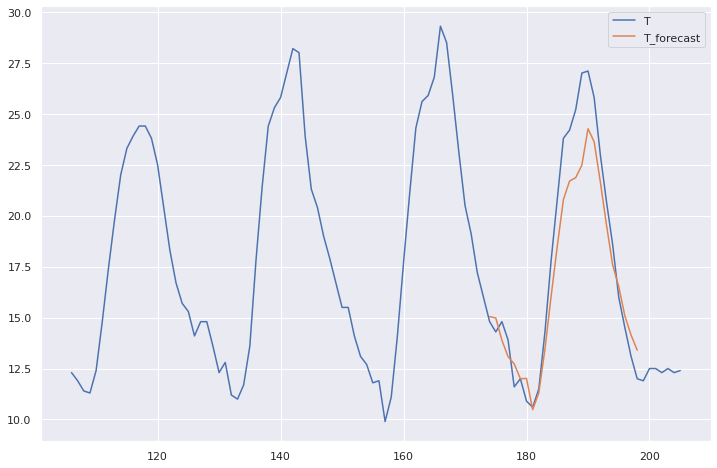

In [36]:
model = sm.tsa.statespace.SARIMAX(df["T"].iloc[:168], order = (1, 0, 0), seasonal_order = (1, 0, 0, 24))
results = model.fit()
df['T_forecast'] = results.predict(start = 168, end = 192, dynamic = True)
df[['T','T_forecast']].iloc[100:200].plot(figsize=(12,8))

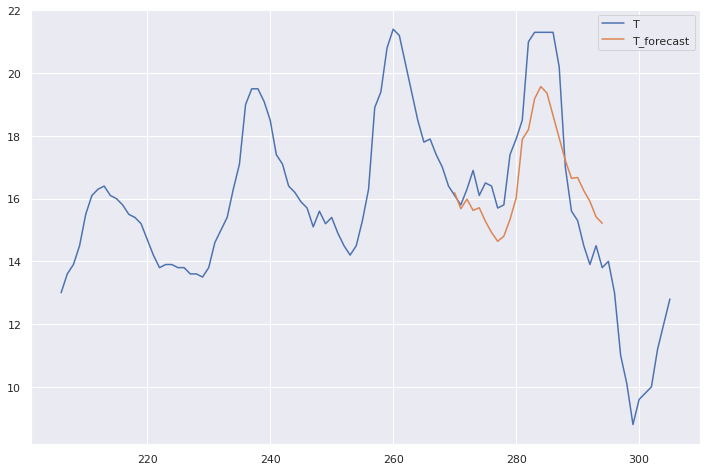

In [51]:
model = sm.tsa.statespace.SARIMAX(df["T"].iloc[96:264], order = (1, 0, 0), seasonal_order = (1, 0, 0, 24))
results = model.fit()
df['T_forecast'] = results.predict(start = 168, end = 192, dynamic = True)
df[['T','T_forecast']].iloc[200:300].plot(figsize=(12,8))

In [55]:
# Adding data cumulatively to the training set
l = []
for i in range(0, 7):
  model = sm.tsa.statespace.SARIMAX(df["T"].iloc[: i * 24 + 168], order = (1, 0, 0), seasonal_order = (1, 0, 0, 24))
  results = model.fit()
  df['T_forecast'] = results.predict(start = 168 + i * 24, end = 192 + i * 24, dynamic = True)
  n = df["T"][i * 24 + 168 : i * 24 + 192].isna().sum()
  one = ((abs(((df["T"][i * 24 + 168 : i * 24 + 192] - df["T_forecast"][i * 24 + 168 : i * 24 + 192]) / df["T"][i * 24 + 168 : i * 24 + 192]).dropna()).sum()) / (24 - n)) * 100
  print(one)
  l.append(one)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


7.15750108333189
16.718237478650288
10.641666162168857
7.095582044185502
7.751258948851538
22.42146517791067
19.82212720218842


In [56]:
# Cumulative
print(sum(l) / 7)

13.086834013898166


In [57]:
# 7 days sliding window for training data 
l = []
for i in range(0, 7):
  model = sm.tsa.statespace.SARIMAX(df["T"].iloc[i * 24: i * 24 + 168], order = (1, 0, 0), seasonal_order = (1, 0, 0, 24))
  results = model.fit()
  df['T_forecast'] = results.predict(start = 168, end = 192, dynamic = True)
  n = df["T"][i * 24 + 168 : i * 24 + 192].isna().sum()
  one = ((abs(((df["T"][i * 24 + 168 : i * 24 + 192] - df["T_forecast"][i * 24 + 168 : i * 24 + 192]) / df["T"][i * 24 + 168 : i * 24 + 192]).dropna()).sum()) / (24 - n)) * 100
  print(one)
  l.append(one)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


7.15750108333189
18.41662468287273
10.535269660344241
6.282457707880192
7.600450881824715
24.053844267341738
19.644141084419772


In [58]:
# 7 day sliding window
print(sum(l) / 7)

13.38432705257361


## Forecasting Carbon Monoxide(CO)

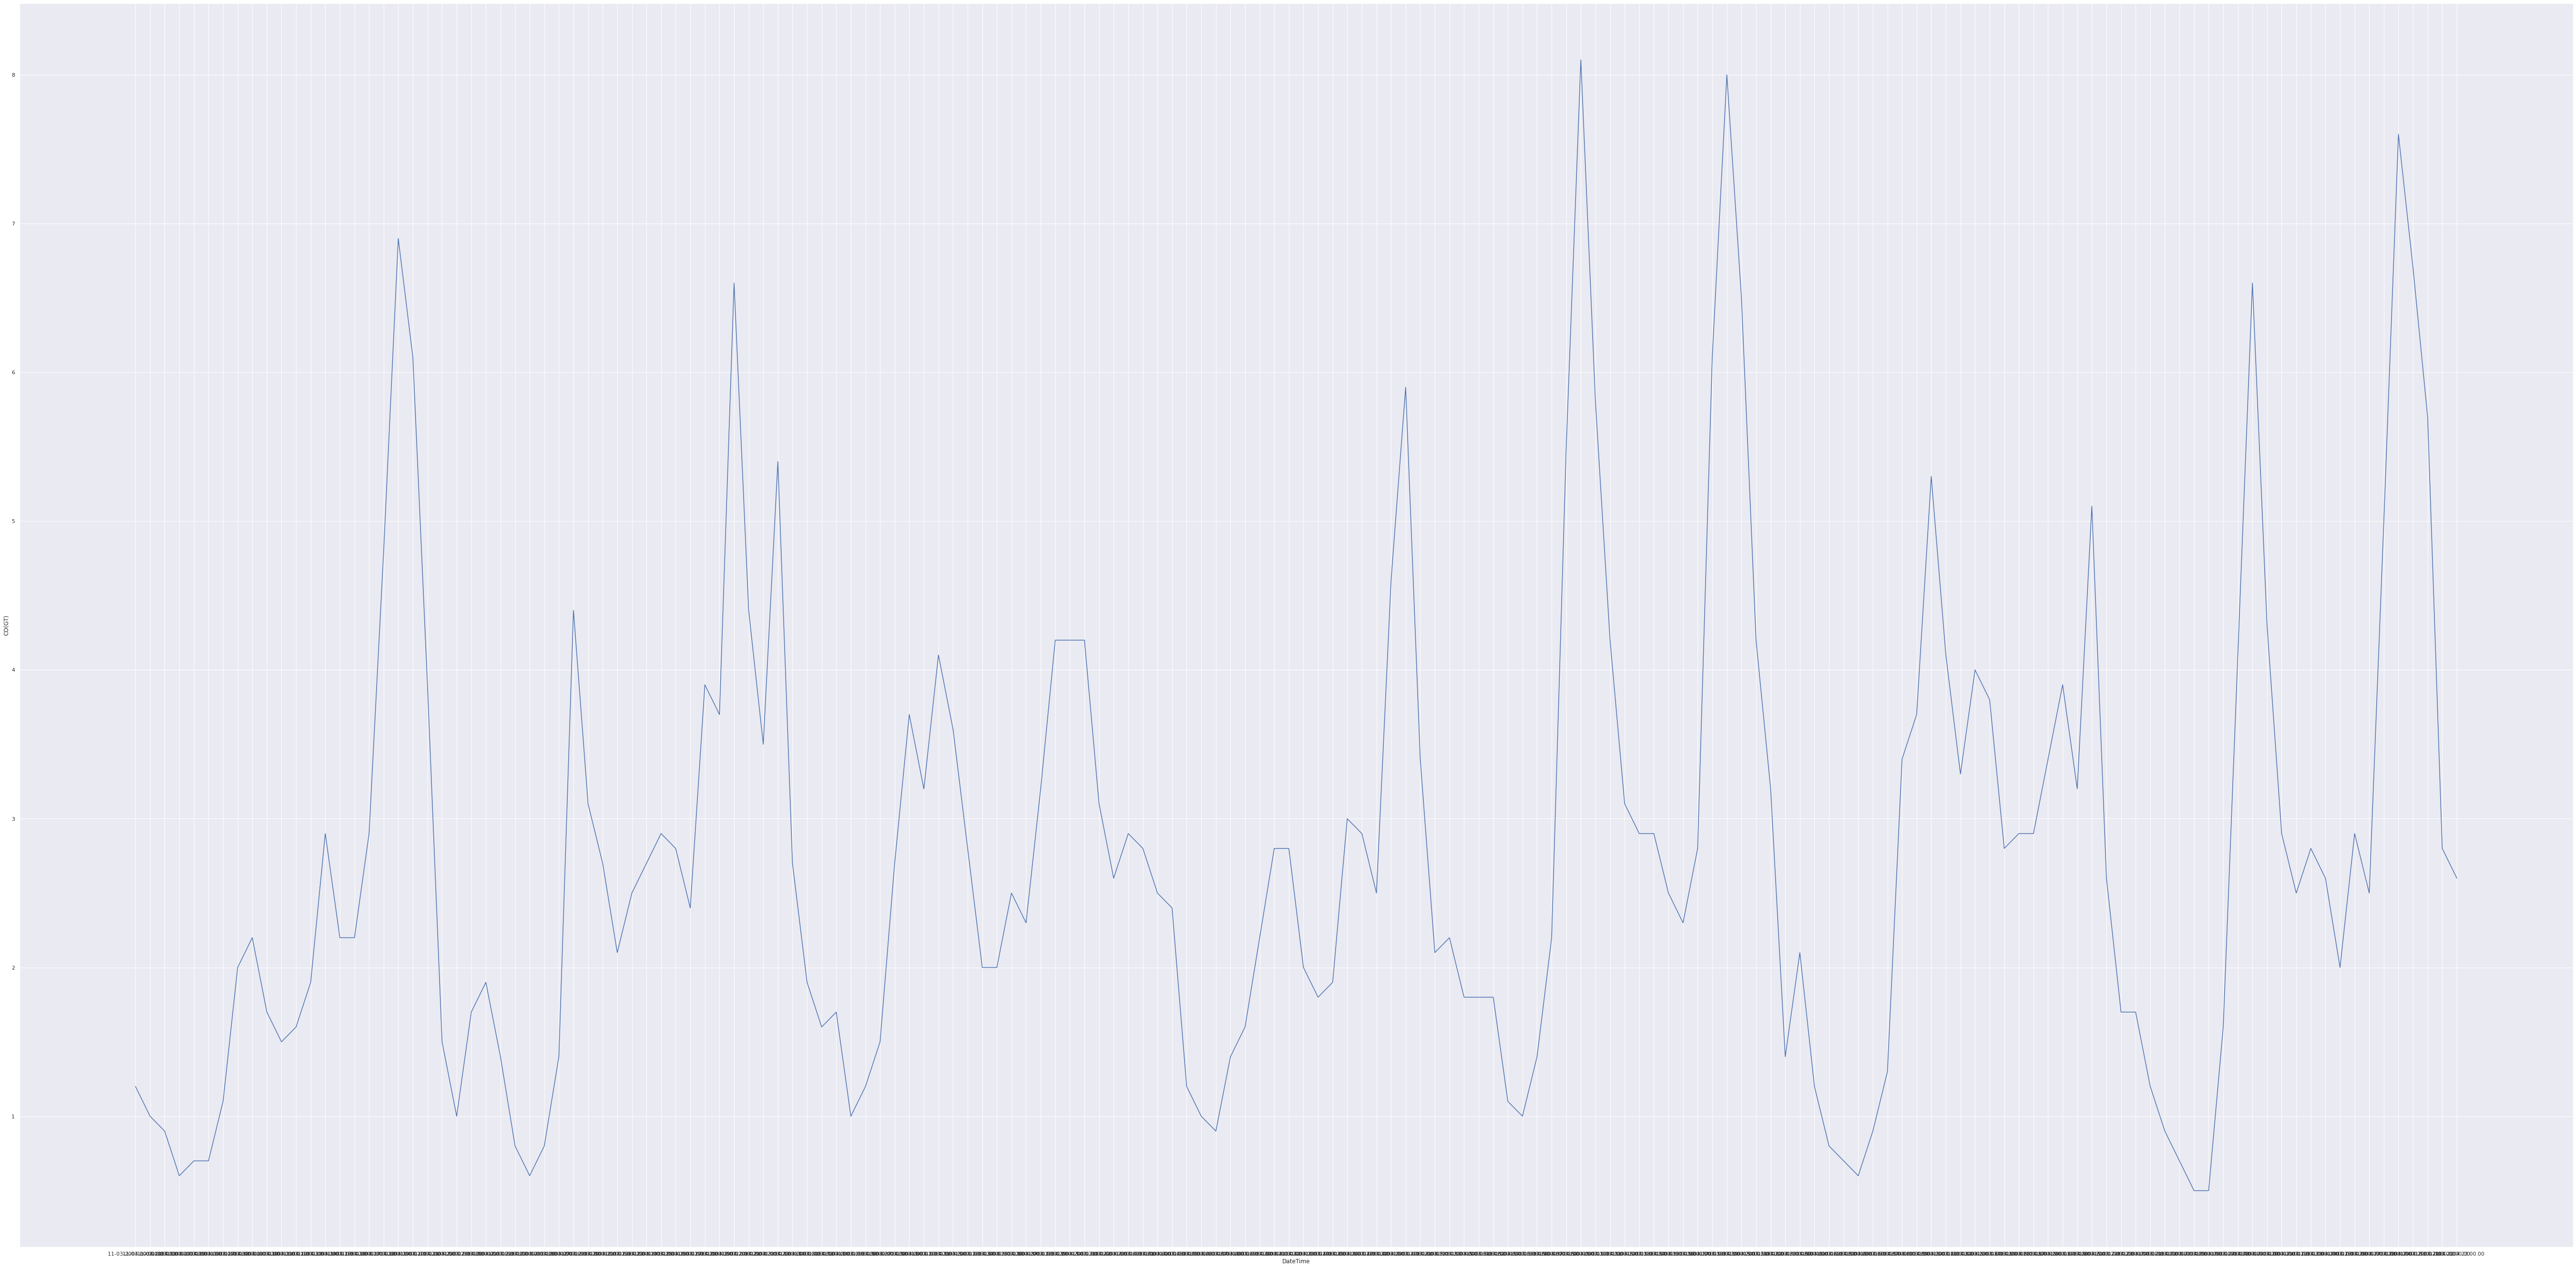

In [64]:
sns.set(rc = {"figure.figsize" : (96, 48)})
sns.lineplot(x = "DateTime", y = "CO(GT)", data = df[:168].dropna())

In [65]:
# Dickey Fuller Test 
from statsmodels.tsa.stattools import adfuller
X = df["CO(GT)"][:168].dropna()
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
 #p-value < 0.05 for stationary

ADF Statistic: -4.502198
p-value: 0.000195
Critical Values:
	1%: -3.475
	5%: -2.881
	10%: -2.577


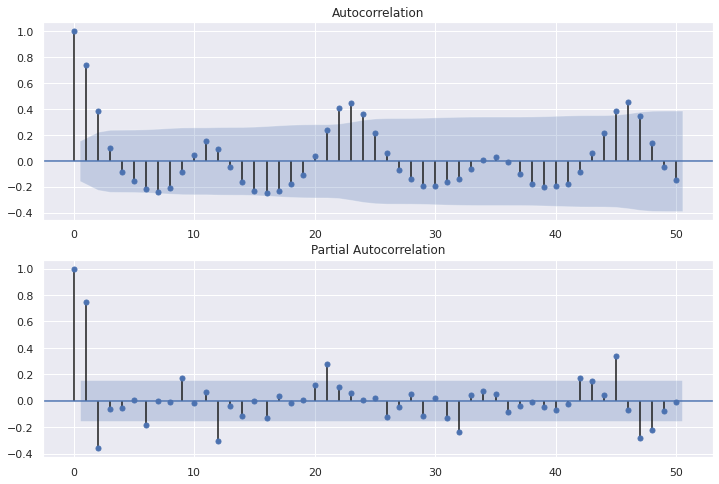

In [66]:
# Autocorrelation and Partial Autocorrelation
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df["CO(GT)"].iloc[:168].dropna(), lags = 50, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df["CO(GT)"].iloc[:168].dropna(), lags = 50, ax = ax2)

In [ ]:
# p = 1 Autregrssion model lags
# d = 0 Differencing
# q = 1 Moving Average lags

In [ ]:
# Prediction Examples for
# 1) Adding data cumulatively to the training set 
# 2) 7 day sliding window

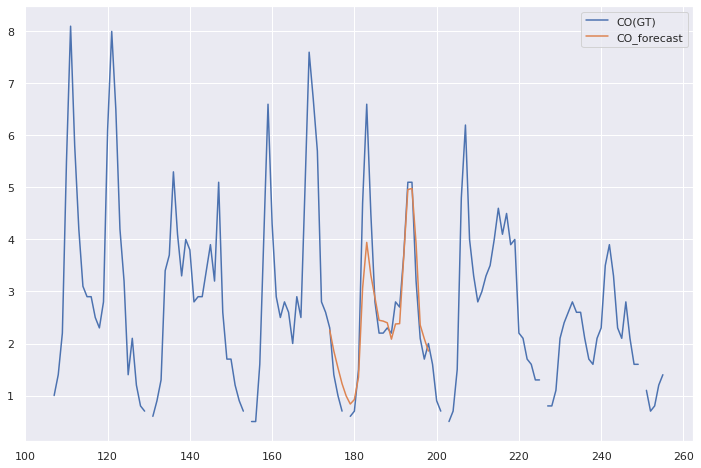

In [73]:
model = sm.tsa.statespace.SARIMAX(df["CO(GT)"].iloc[:168], order = (1, 0, 1), seasonal_order = (1, 0, 1, 24))
results = model.fit()
df['CO_forecast'] = results.predict(start = 168, end = 192, dynamic = True)
df[['CO(GT)','CO_forecast']].iloc[100:250].plot(figsize=(12,8))

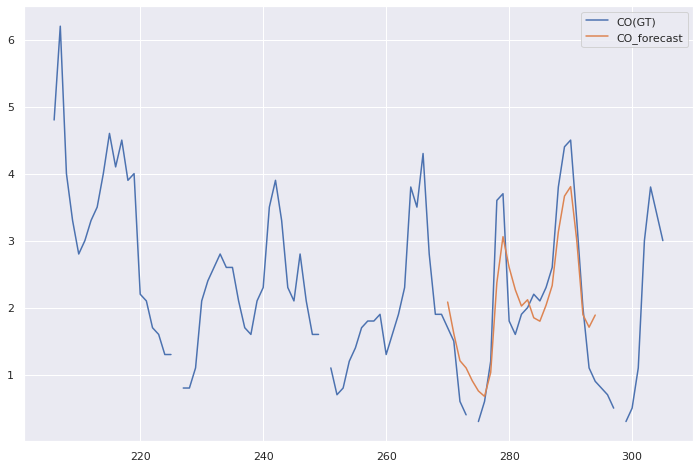

In [74]:
model = sm.tsa.statespace.SARIMAX(df["CO(GT)"].iloc[96: 264], order = (1, 0, 1), seasonal_order = (1, 0, 1, 24))
results = model.fit()
df['CO_forecast'] = results.predict(start = 168, end = 192, dynamic = True)
df[['CO(GT)','CO_forecast']].iloc[200:300].plot(figsize=(12,8))

In [75]:
# Adding data cumulatively to the training set
l = []
for i in range(0, 7):
  model = sm.tsa.statespace.SARIMAX(df["CO(GT)"].iloc[: i * 24 + 168], order = (1, 0, 1), seasonal_order = (1, 0, 1, 24))
  results = model.fit()
  df['CO_forecast'] = results.predict(start = 168 + i * 24, end = 192 + i * 24, dynamic = True)
  n = df["CO(GT)"][i * 24 + 168 : i * 24 + 192].isna().sum()
  one = ((abs(((df["CO(GT)"][i * 24 + 168 : i * 24 + 192] - df["CO_forecast"][i * 24 + 168 : i * 24 + 192]) / df["CO(GT)"][i * 24 + 168 : i * 24 + 192]).dropna()).sum()) / (24 - n)) * 100
  print(one)
  l.append(one)

20.431543697088365
20.527549504914653
27.5187132219326
51.33107825513129
35.455455521341904
37.1597525996471
20.555886056426857


In [76]:
# Cumulative
print(sum(l) / 7)

30.425711265211824


In [77]:
# 7 days sliding window for training data
l = []
for i in range(0, 7):
  model = sm.tsa.statespace.SARIMAX(df["CO(GT)"].iloc[i * 24: i * 24 + 168], order = (1, 0, 1), seasonal_order = (1, 0, 1, 24))
  results = model.fit()
  df['CO_forecast'] = results.predict(start = 168, end = 192, dynamic = True)
  n = df["CO(GT)"][i * 24 + 168 : i * 24 + 192].isna().sum()
  one = ((abs(((df["CO(GT)"][i * 24 + 168 : i * 24 + 192] - df["CO_forecast"][i * 24 + 168 : i * 24 + 192]) / df["CO(GT)"][i * 24 + 168 : i * 24 + 192]).dropna()).sum()) / (24 - n)) * 100
  print(one)
  l.append(one)

20.431543697088365
18.251331272997575
28.40753180615475
51.26244820005628
35.07352195942088
27.63477342968258
20.30686608381439


In [116]:
# 7 day sliding window
print(sum(l) / 7)

28.76685949274497